In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random

In [3]:

#随机生成城市
def generate_random_cities(city_num,base_rand):
    cities = []
    for i in range(city_num):
        city = []
        for j in range(2):
            city.append(random.randint(0, base_rand))
        cities.append(city)
    return cities

def price_cn(vec1, vec2):
    return np.linalg.norm(np.array(vec1) - np.array(vec2))

def calc_distance(distance,path):
    dis = 0.0
    for i in range(len(path) - 1):
        dis += distance[path[i]][path[i+1]]
    return dis

#计算城市之间的距离
def compute_distance(cities,city_num):
    distances = np.zeros((city_num, city_num))
    for i, curr_point in enumerate(cities):
        line = []
        for j ,other_point in enumerate(cities):
            if i!=j:
                line.append(price_cn(curr_point, other_point))
            else:
                line.append(0.0)
        distances[i] = line
    return distances

# 更新神经网络的输出电压V
def calc_V(U, U0):
    return 1 / 2 * (1 + np.tanh(U / U0))

# 更新神经网络的输入电压U
def calc_U(U, du, step):
    return U + du * step

# 计算当前网络的能量
def calc_energy(V, distance,N,A,D):
    t1 = np.sum(np.power(np.sum(V, axis=0) - 1, 2))
    t2 = np.sum(np.power(np.sum(V, axis=1) - 1, 2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = distance * Vt
    t3 = np.sum(np.sum(np.multiply(V, t3)))
    e = 0.5 * (A * (t1 + t2) + D * t3)
    return e

# 动态方程计算微分方程du
def calc_du(V, distance,N,A,D):
    a = np.sum(V, axis=0) - 1  # 按列相加
    b = np.sum(V, axis=1) - 1  # 按行相加
    t1 = np.zeros((N, N))
    t2 = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            t1[i, j] = a[j]
    for i in range(N):
        for j in range(N):
            t2[j, i] = b[j]
    # 将第一列移动到最后一列
    c_1 = V[:, 1:N]
    c_0 = np.zeros((N, 1))
    c_0[:, 0] = V[:, 0]
    c = np.concatenate((c_1, c_0), axis=1)
    c = np.dot(distance, c)
    return -A * (t1 + t2) - D * c

# 检查路径的正确性
def check_path(V,N):
    newV = np.zeros([N, N])
    route = []
    for i in range(N):
        mm = np.max(V[:, i])
        for j in range(N):
            if V[j, i] == mm:
                newV[j, i] = 1
                route += [j]
                break
    return route, newV

# 可视化画出哈密顿回路和能量趋势
def draw_H_and_E(citys, H_path, energys):
    fig = plt.figure()
    # 绘制哈密顿回路
    ax1 = fig.add_subplot(121)
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    for (from_, to_) in H_path:
        p1 = plt.Circle(citys[from_], 0.2, color='red')
        p2 = plt.Circle(citys[to_], 0.2, color='red')
        ax1.add_patch(p1)
        ax1.add_patch(p2)
        ax1.plot((citys[from_][0], citys[to_][0]), (citys[from_][1], citys[to_][1]), color='red')
        ax1.annotate(s=chr(97 + to_), xy=citys[to_], xytext=(-8, -4), textcoords='offset points', fontsize=20)
    ax1.axis('equal')
    ax1.grid()
    # 绘制能量趋势图
    ax2 = fig.add_subplot(122)
    ax2.plot(np.arange(0, len(energys), 1), energys, color='red')
    plt.show()

def Hopfield_TSP(city_num,base_rand):
    cities = generate_random_cities(city_num,base_rand)
    distance = compute_distance(cities,city_num)
    N = city_num
    #初始化网络初值
    A = N*N
    D = N/2
    U0 = 0.0009 # 初始电压
    step = 0.0001  # 步长
    num_iter = 10000  # 迭代次数
    # 初始化神经网络的输入状态（电路的输入电压U）
    U = 1 / 2 * U0 * np.log(N - 1) + (2 * (np.random.random((N, N))) - 1)
    # 初始化神经网络的输出状态（电路的输出电压V）
    V = calc_V(U, U0)
    energys = np.array([0.0 for x in range(num_iter)])  # 每次迭代的能量
    best_distance = np.inf  # 最优距离
    best_route = []  # 最优路线
    H_path = []  # 哈密顿回路
    # 开始迭代训练网络
    for n in range(num_iter):
        # 利用动态方程计算du
        du = calc_du(V, distance,N,A,D)
        # 由一阶欧拉法更新下一个时间的输入状态（电路的输入电压U）
        U = calc_U(U, du, step)
        # 由sigmoid函数更新下一个时间的输出状态（电路的输出电压V）
        V = calc_V(U, U0)
        # 计算当前网络的能量E
        energys[n] = calc_energy(V, distance,N,A,D)
        # 检查路径的合法性
        route, newV = check_path(V,N)
        if len(np.unique(route)) == N:
            route.append(route[0])
            dis = calc_distance(distance,route)
            if dis < best_distance:
                H_path = []
                best_distance = dis
                best_route = route
                [H_path.append((route[i], route[i + 1])) for i in range(len(route) - 1)]
                print('第{}次迭代找到的次优解距离为：{}，能量为：{}'.format(n, best_distance, energys[n]))
    if len(H_path) > 0:
        draw_H_and_E(cities, H_path, energys)
    else:
        print('没有找到最优解')

第72次迭代找到的次优解距离为：62.44412358076161，能量为：426.5526241888491
第409次迭代找到的次优解距离为：43.74476662593097，能量为：335.31703409440445
第423次迭代找到的次优解距离为：36.04370369141671，能量为：495.3709026138216
第1805次迭代找到的次优解距离为：35.346917492044724，能量为：419.8032750484113
第3401次迭代找到的次优解距离为：34.65006649067242，能量为：206.2514067681932
第4954次迭代找到的次优解距离为：34.48982844908465，能量为：320.88900948359037


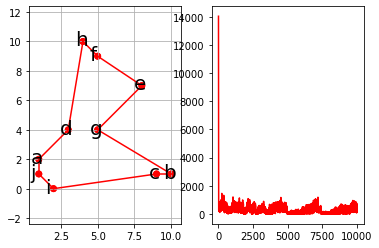

In [48]:
Hopfield_TSP(10,10)

第446次迭代找到的次优解距离为：254.38501509607028，能量为：2702.1430932377857
第669次迭代找到的次优解距离为：234.13819389413163，能量为：3592.6653690855455


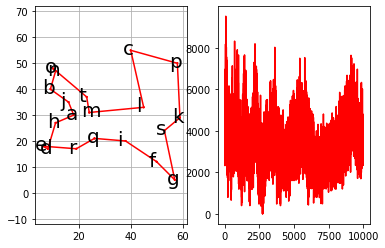

In [49]:
Hopfield_TSP(20,60)

第927次迭代找到的次优解距离为：426.08105768087，能量为：9078.353089670543
第1365次迭代找到的次优解距离为：416.03450182547306，能量为：5184.727127723574
第3547次迭代找到的次优解距离为：414.2989431620833，能量为：3491.9289264451086


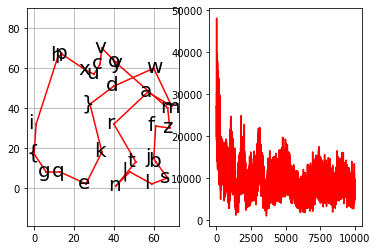

In [50]:
Hopfield_TSP(30,70)

In [4]:
Hopfield_TSP(40,80)

没有找到最优解
